In [1]:
# importing required libraries
import numpy as np
import pandas as pd
import pickle # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import (StandardScaler, OrdinalEncoder,LabelEncoder, MinMaxScaler, OneHotEncoder)
from sklearn.preprocessing import Normalizer, MaxAbsScaler , RobustScaler, PowerTransformer

# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score # for calculating accuracy of model
from sklearn.model_selection import train_test_split # for splitting the dataset for training and testing
from sklearn.metrics import classification_report # for generating a classification report of model

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout # importing dense layer
from keras.models import Sequential #importing Sequential layer
from keras.layers import Input
from keras.models import Model
# representation of model layers
#from keras.utils.vis_utils import plot_model

In [2]:
feature=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count", 
          "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]



In [3]:
train_data=pd.read_csv('C:/Users/Nimish Bhatt/Downloads/archive (34)/KDDTrain+.txt',delimiter=',', header=None,names=feature)
test_data=pd.read_csv('C:/Users/Nimish Bhatt/Downloads/archive (34)/KDDTest+.txt',delimiter=',', header=None,names=feature)

In [4]:
# remove attribute 'difficulty_level'
train_data.drop(['difficulty'],axis=1,inplace=True)
train_data.shape

(125973, 42)

In [5]:
# number of attack labels 
train_data['label'].value_counts()

label
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64

In [6]:
def change_label(df):
  df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
  df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)      
  df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
  df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

In [7]:
change_label(train_data)

C:\Users\Nimish Bhatt\AppData\Local\Temp\ipykernel_1504\3797573636.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)


In [8]:
# creating a dataframe with multi-class labels (Dos,Probe,R2L,U2R,normal)
multi_data = train_data.copy()
multi_label = pd.DataFrame(multi_data.label)

In [9]:
# using standard scaler for normalizing
std_scaler = StandardScaler()
def standardization(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
  return df

numeric_col = multi_data.select_dtypes(include='number').columns
data = standardization(multi_data,numeric_col)

In [10]:
# label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)
le2 = preprocessing.LabelEncoder()
enc_label = multi_label.apply(le2.fit_transform)
multi_data['intrusion'] = enc_label
#y_mul = multi_data['intrusion']
multi_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,intrusion
0,-0.110249,tcp,ftp_data,SF,-0.007679,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.782367,-0.280282,0.069972,-0.289103,-0.639532,-0.624871,-0.224532,-0.376387,normal,4
1,-0.110249,udp,other,SF,-0.007737,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-1.161030,2.736852,2.367737,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,normal,4
2,-0.110249,tcp,private,S0,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.938287,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,Dos,0
3,-0.110249,tcp,http,SF,-0.007723,-0.002891,-0.014089,-0.089486,-0.007736,-0.095076,...,1.066401,-0.439078,-0.383108,0.066252,-0.572083,-0.602433,-0.387635,-0.345084,normal,4
4,-0.110249,tcp,http,SF,-0.007728,-0.004814,-0.014089,-0.089486,-0.007736,-0.095076,...,1.066401,-0.439078,-0.480197,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,normal,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,-0.110249,tcp,private,S0,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.938287,-0.121485,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,Dos,0
125969,-0.107178,udp,private,SF,-0.007744,-0.004883,-0.014089,-0.089486,-0.007736,-0.095076,...,0.977304,-0.386146,-0.447834,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,normal,4
125970,-0.110249,tcp,smtp,SF,-0.007382,-0.004823,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.893738,-0.121485,-0.480197,-0.289103,0.979238,-0.624871,-0.355014,-0.376387,normal,4
125971,-0.110249,tcp,klogin,S0,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-1.094207,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,Dos,0


In [11]:
multi_data.drop(labels= [ 'label'], axis=1, inplace=True)
multi_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,intrusion
0,-0.110249,tcp,ftp_data,SF,-0.007679,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.818890,-0.782367,-0.280282,0.069972,-0.289103,-0.639532,-0.624871,-0.224532,-0.376387,4
1,-0.110249,udp,other,SF,-0.007737,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-1.035688,-1.161030,2.736852,2.367737,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,4
2,-0.110249,tcp,private,S0,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.809857,-0.938287,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,0
3,-0.110249,tcp,http,SF,-0.007723,-0.002891,-0.014089,-0.089486,-0.007736,-0.095076,...,1.258754,1.066401,-0.439078,-0.383108,0.066252,-0.572083,-0.602433,-0.387635,-0.345084,4
4,-0.110249,tcp,http,SF,-0.007728,-0.004814,-0.014089,-0.089486,-0.007736,-0.095076,...,1.258754,1.066401,-0.439078,-0.480197,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,-0.110249,tcp,private,S0,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.818890,-0.938287,-0.121485,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,0
125969,-0.107178,udp,private,SF,-0.007744,-0.004883,-0.014089,-0.089486,-0.007736,-0.095076,...,1.159389,0.977304,-0.386146,-0.447834,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,4
125970,-0.110249,tcp,smtp,SF,-0.007382,-0.004823,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.773724,-0.893738,-0.121485,-0.480197,-0.289103,0.979238,-0.624871,-0.355014,-0.376387,4
125971,-0.110249,tcp,klogin,S0,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.972455,-1.094207,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,0


In [12]:
# one-hot-encoding attack label
multi_data = pd.get_dummies(multi_data,columns=['protocol_type','service','flag'],prefix="",prefix_sep="")  
multi_data

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,REJ,RSTO,RSTOS0,RSTR,S0,S1,S2,S3,SF,SH
0,-0.110249,-0.007679,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,False,False,False,False,False,False,False,False,True,False
1,-0.110249,-0.007737,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,False,False,False,False,False,False,False,False,True,False
2,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,False,False,False,False,True,False,False,False,False,False
3,-0.110249,-0.007723,-0.002891,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,1.235694,-0.011664,...,False,False,False,False,False,False,False,False,True,False
4,-0.110249,-0.007728,-0.004814,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,1.235694,-0.011664,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,False,False,False,False,True,False,False,False,False,False
125969,-0.107178,-0.007744,-0.004883,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,False,False,False,False,False,False,False,False,True,False
125970,-0.110249,-0.007382,-0.004823,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,1.235694,-0.011664,...,False,False,False,False,False,False,False,False,True,False
125971,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,False,False,False,False,True,False,False,False,False,False


In [13]:
# Replace True with 1 and False with 2
multi_data.replace({True: 1, False: 0}, inplace=True)

# Check the result
print(multi_data.head())


C:\Users\Nimish Bhatt\AppData\Local\Temp\ipykernel_1504\1583274546.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  multi_data.replace({True: 1, False: 0}, inplace=True)


   duration  src_bytes  dst_bytes      land  wrong_fragment    urgent  \
0 -0.110249  -0.007679  -0.004919 -0.014089       -0.089486 -0.007736   
1 -0.110249  -0.007737  -0.004919 -0.014089       -0.089486 -0.007736   
2 -0.110249  -0.007762  -0.004919 -0.014089       -0.089486 -0.007736   
3 -0.110249  -0.007723  -0.002891 -0.014089       -0.089486 -0.007736   
4 -0.110249  -0.007728  -0.004814 -0.014089       -0.089486 -0.007736   

        hot  num_failed_logins  logged_in  num_compromised  ...  REJ  RSTO  \
0 -0.095076          -0.027023  -0.809262        -0.011664  ...    0     0   
1 -0.095076          -0.027023  -0.809262        -0.011664  ...    0     0   
2 -0.095076          -0.027023  -0.809262        -0.011664  ...    0     0   
3 -0.095076          -0.027023   1.235694        -0.011664  ...    0     0   
4 -0.095076          -0.027023   1.235694        -0.011664  ...    0     0   

   RSTOS0  RSTR  S0  S1  S2  S3  SF  SH  
0       0     0   0   0   0   0   1   0  
1       

In [14]:
y_train_multi= multi_data[['intrusion']]
X_train_multi= multi_data.drop(labels=['intrusion'], axis=1)

print('X_train has shape:',X_train_multi.shape,'\ny_train has shape:',y_train_multi.shape)

X_train has shape: (125973, 122) 
y_train has shape: (125973, 1)


In [15]:
from sklearn.preprocessing import LabelBinarizer

y_train_multi = LabelBinarizer().fit_transform(y_train_multi)
y_train_multi

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1]])

In [16]:
X_train_multi=np.array(X_train_multi)
y_train_multi=np.array(y_train_multi)

In [17]:
# splitting the dataset 80% for training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_train_multi,y_train_multi, test_size=0.20, random_state=42)

In [18]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(100778, 122, 1)

In [19]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(25195, 122, 1)

In [20]:
model = Sequential() # initializing model
# input layer and first layer with 50 neurons
model.add(Conv1D(32, 3, padding="same",input_shape = (X_train.shape[1], 1), activation='relu'))
model.add(MaxPool1D(pool_size=(4)))  
model.add(Dropout(0.2))
model.add(Conv1D(32, 3, padding="same", activation='relu'))
model.add(MaxPool1D(pool_size=(4)))  
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=50))
# output layer with softmax activation
model.add(Dense(units=5,activation='softmax'))

c:\Users\Nimish Bhatt\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# defining loss function, optimizer, metrics and then compiling model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
# summary of model layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 122, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 7, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        11,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,737 (57.57 KB)

 Trainable params: 14,737 (57.57 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# training the model on training dataset
history = model.fit(X_train, y_train, epochs=100, batch_size=5000,validation_split=0.2)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.4127 - loss: 1.4421 - val_accuracy: 0.7908 - val_loss: 0.7789
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.7761 - loss: 0.7307 - val_accuracy: 0.8763 - val_loss: 0.4779
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.8607 - loss: 0.4891 - val_accuracy: 0.9216 - val_loss: 0.3060
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.8989 - loss: 0.3479 - val_accuracy: 0.9290 - val_loss: 0.2430
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.9121 - loss: 0.3004 - val_accuracy: 0.9437 - val_loss: 0.2115
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.9257 - loss: 0.2589 - val_accuracy: 0.9490 - val_loss: 0.1903
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.9342 - loss: 0.2280 - val_accuracy: 0.9545 - val_loss: 0.1737
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.9385 - loss: 0.2165 - val_accu

In [26]:
# Save the trained model to a file
model.save('lstm.keras')

In [24]:
# predicting target attribute on testing dataset
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

788/788 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9879 - loss: 0.0369
Test results - Loss: 0.03992681950330734 - Accuracy: 98.80532026290894%


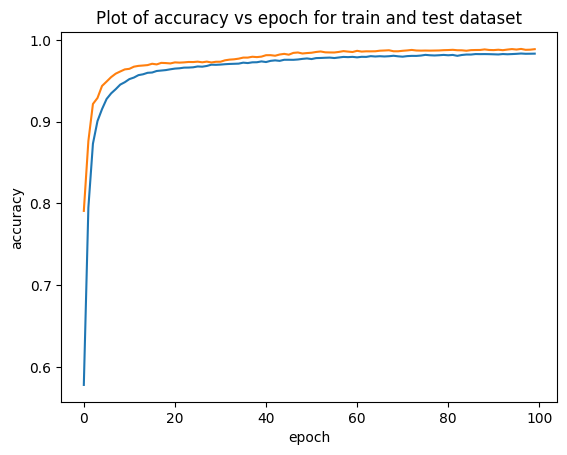

In [25]:
# Plot of accuracy vs epoch for train and test dataset
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Plot of accuracy vs epoch for train and test dataset")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [27]:
y_pred_test = model.predict(X_test, batch_size=500)

# For Plot curve
y_pred_evaluation_test = to_categorical(np.argmax(y_pred_test, axis=1), 5)

# For evaluation
y_pred_argmax_test=(np.argmax(y_pred_test, axis=1))

y_test_argmax=(np.argmax(y_test, axis=1))

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [28]:
# Calculating Area under the curve
def AUC(actual_class, pred_class, average = "micro"):
    
    #Making a set of all the unique classes 
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #Making a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #Making the current class with label 1 and all other classes as a label 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        # Calculating the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [29]:
def plot_roc_curve(y_test,y_pred, classes):
    n_classes=len(classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw=2
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
    plt.figure(figsize=(10, 10))
    plt.plot(fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,)

    plt.plot(fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
           fpr[i],
           tpr[i],
           color=color,
           lw=lw,
        label="ROC curve of {0} (area = {1:0.2f})".format(classes[i], roc_auc[i]),
    )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("AUC")
    plt.legend(loc="lower right")
    plt.show()

In [30]:
import itertools
from itertools import cycle

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Prints and plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [32]:
# predicting target attribute on testing dataset
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

788/788 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9879 - loss: 0.0369
Test results - Loss: 0.03992681950330734 - Accuracy: 98.80532026290894%


In [33]:
print('AUC Score is on Test : ' , AUC(y_test_argmax, y_pred_argmax_test))

AUC Score is on Test :  {0: 0.997832535214837, 1: 0.9819798898611953, 2: 0.8389853658815655, 3: 0.5454346915790689, 4: 0.9883090895810421}


In [34]:
from sklearn.metrics import classification_report
classes=['normal', 'Dos','Probe', 'R2L','U2R']

print("Classification Report on Data Test \n" , classification_report(y_test_argmax, y_pred_argmax_test, target_names=classes))

Classification Report on Data Test 
               precision    recall  f1-score   support

      normal       1.00      1.00      1.00      9181
         Dos       0.97      0.97      0.97      2357
       Probe       0.91      0.68      0.78       224
         R2L       0.50      0.09      0.15        11
         U2R       0.99      0.99      0.99     13422

    accuracy                           0.99     25195
   macro avg       0.87      0.75      0.78     25195
weighted avg       0.99      0.99      0.99     25195



Confusion matrix, without normalization


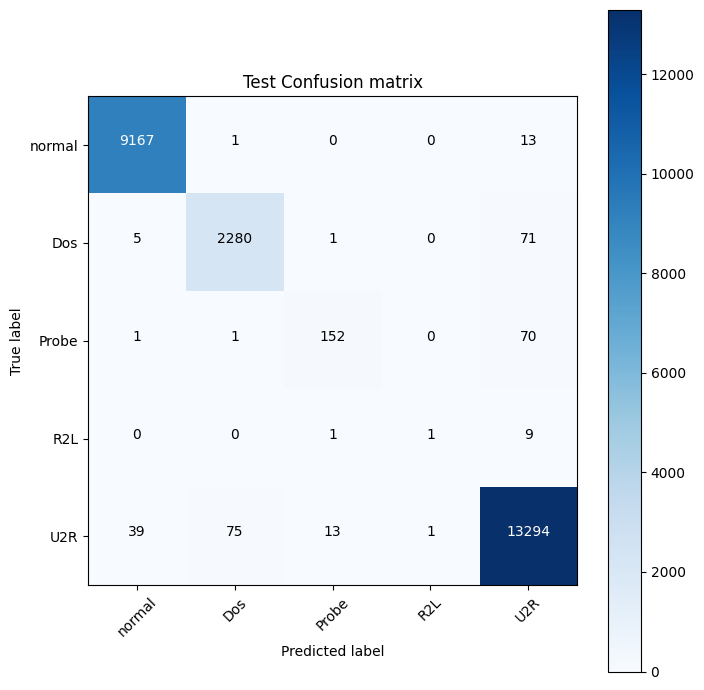

In [35]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test_argmax, y_pred_argmax_test)

# Plot non-normalized confusion matrix
plt.figure(figsize=(7, 7))
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Test Confusion matrix')
plt.show()

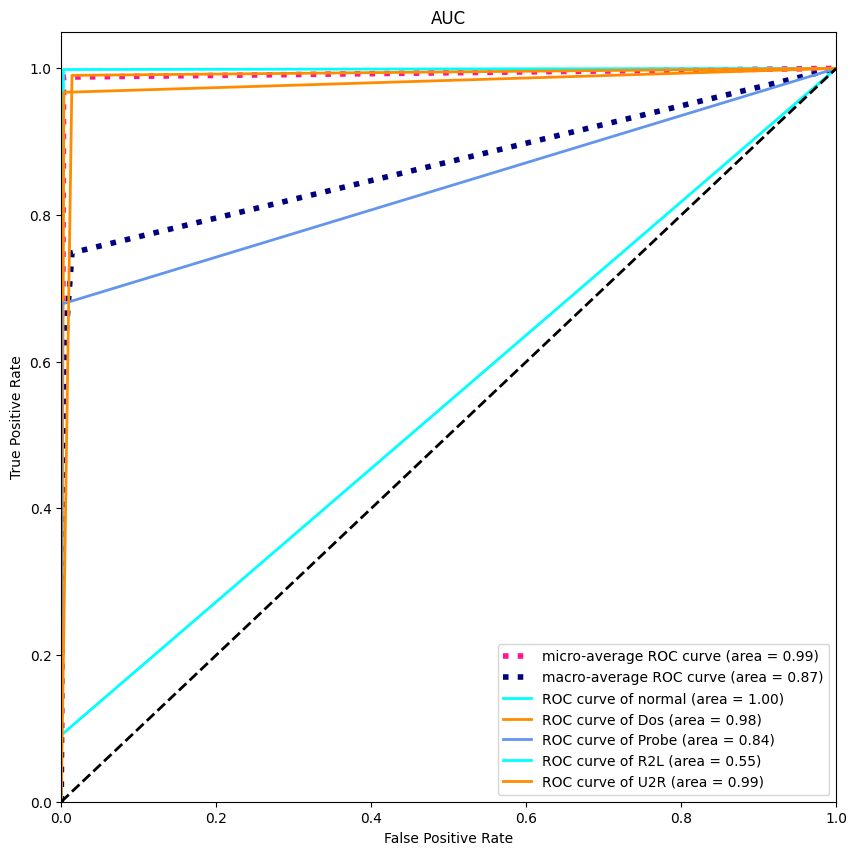

In [36]:
plot_roc_curve(y_test,y_pred_evaluation_test,classes=classes)
